In [1]:
import keras
import tensorflow as tf
import os, sys
import numpy as np
import pandas as pd  
from random import random

os.environ["CUDA_VISIBLE_DEVICES"]="1"

print("python:{}, keras:{}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


python:3.5.2 (default, Nov 17 2016, 17:05:23) 
[GCC 5.4.0 20160609], keras:2.0.3, tensorflow: 1.0.1


In [2]:
in_out_neurons = 2
hidden_neurons = 30

model = Sequential()
model.add(LSTM(hidden_neurons, return_sequences=False,
               input_shape=(None, in_out_neurons)))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [8]:
def transform_input(data, n_prev=3):
    """
    Helper function for splitting the data into train/test sets.
    Returns pair of features and the corresponding predicted / ground truth value.
    @data pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data) - n_prev):
        docX.append(data.iloc[i:i + n_prev].as_matrix())
        docY.append(data.iloc[i + n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

In [4]:
def train_test_split(df, test_size=0.1):  
    """
    Split the data into train/test sets.
    """
    ntrn = round(len(df) * (1 - test_size))

    X_train, y_train = transform_input(df.iloc[0:ntrn])
    X_test, y_test = transform_input(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

In [5]:
def predict_test_counts(prev_counts):
    """
    Predict future profile counts based on multiple lists of given
    profile counts of a given dimensionality.
    """
    profile_info_dict = {}
    for i in range(len(prev_counts)):
        profile_info_dict[str(i)] = prev_counts[i];
    total_input = pd.DataFrame(profile_info_dict)

    # retrieve data
    (X_train, y_train), (X_test, y_test) = train_test_split(total_input)

    # train the model
    model.fit(X_train, y_train, batch_size=45, epochs=10, validation_split=0.05)

    predicted = model.predict(X_test)  
    rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))

    # for now we're only interested in the first 
    return predicted

In [42]:
prev_counts = [[1, 1], [1, 2], [1, 4], [1, 8]]
prev_counts = [[1, 1, 1, 1] * 100,
               [1, 2, 4, 8] * 100]

profile_info_dict = {}
for i in range(len(prev_counts)):
    profile_info_dict[str(i)] = prev_counts[i];
total_input = pd.DataFrame(profile_info_dict)

In [43]:
(X_train, y_train) = transform_input(total_input, 4)

In [50]:
X_train[:3]

array([[[1, 1],
        [1, 2],
        [1, 4],
        [1, 8]],

       [[1, 2],
        [1, 4],
        [1, 8],
        [1, 1]],

       [[1, 4],
        [1, 8],
        [1, 1],
        [1, 2]]])

In [51]:
y_train[:3]

array([[1, 1],
       [1, 2],
       [1, 4]])

In [83]:
X_test = []
X_test.append(total_input.iloc[len(prev_counts[0]) - 4:].as_matrix())
X_test = np.array(X_test)

In [85]:
X_test

array([[[1, 1],
        [1, 2],
        [1, 4],
        [1, 8]]])

In [71]:
# train the model
model.fit(X_train, y_train, batch_size=45, epochs=10, validation_split=0.5)

Train on 198 samples, validate on 198 samples
Epoch 1/10
198/198 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0087
Epoch 2/10
198/198 [==============================] - 0s - loss: 0.0042 - val_loss: 5.3039e-04
Epoch 3/10
198/198 [==============================] - 0s - loss: 3.8887e-04 - val_loss: 3.1203e-04
Epoch 4/10
198/198 [==============================] - 0s - loss: 9.4796e-04 - val_loss: 0.0050
Epoch 5/10
198/198 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0022
Epoch 6/10
198/198 [==============================] - 0s - loss: 0.0010 - val_loss: 9.0666e-04
Epoch 7/10
198/198 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0025
Epoch 8/10
198/198 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0014
Epoch 9/10
198/198 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0016
Epoch 10/10
198/198 [==============================] - 0s - loss: 0.0023 - val_loss: 0.0017


In [72]:
predicted = model.predict(X_test)

In [73]:
predicted

array([[ 1.00658631,  8.03395748]], dtype=float32)

In [58]:
total_input_t = total_input.transpose()
total_input_plot = np.array([total_input_t[col].tolist() for col in total_input_t])

In [59]:
total_input_plot.shape

(400, 2)

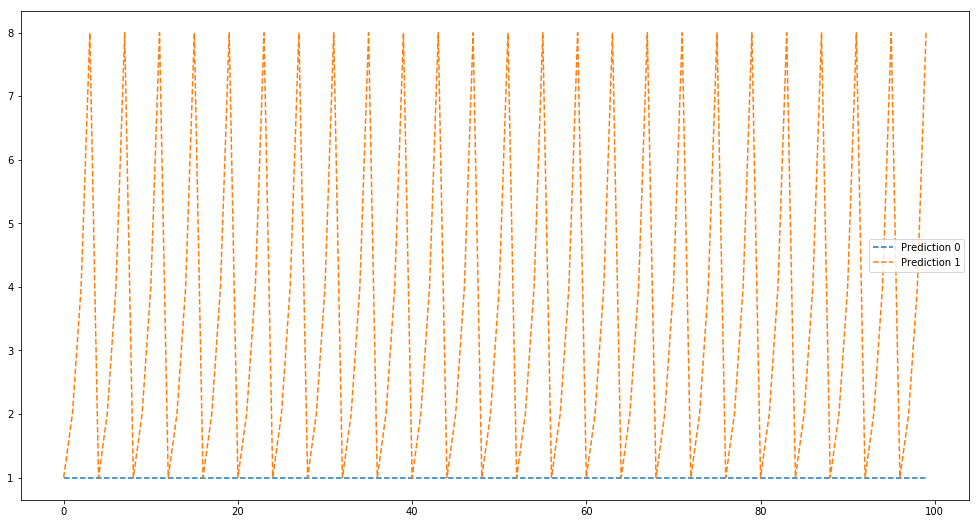

In [60]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (17, 9)
plt.plot(total_input_plot[-100:][:, 0], "--")
plt.plot(total_input_plot[-100:][:, 1], "--")
plt.legend(["Input 0", "Inpput 1"])